Before actually doing outlier runs, ensure you have a working version of `discovery`, `numpyro`, and `jax`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, re
import discovery as ds
from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
import numpyro
from numpyro import distributions as dist, infer
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
import sys
from loguru import logger
import jax.scipy.linalg as jsl
import json
from discovery import selection_backend_flags, matrix
#import outlier_utils as ou

In [13]:
import pint_pal.lite_utils as lu
import pint_pal.noise_utils as nu
# from pint_pal.par_checker import *
from pint_pal import utils
from pint_pal.dmx_utils import setup_dmx, model_dmx_params, apply_frequency_ratio_cuts
from pint_pal.timingconfiguration import TimingConfiguration
from pint_pal.utils import apply_cut_flag, apply_cut_select
from pint_pal.plot_utils import plot_residuals_time
from pint_pal import outlier_utils as ou
from enterprise.pulsar import Pulsar as ePulsar
import yaml
from astropy import log
import pint.fitter
from pint.utils import dmxparse

In [5]:
log.setLevel("WARNING") # Set desired verbosity of log statements (DEBUG/INFO/WARNING/ERROR)
log_to_file = False

lu.git_config_info()

In [6]:
# Notebook run settings
autorun = False
analyze_postfit = True # was originally false jgb
run_outlier_analysis = True # was originally false jgb
use_outlier_results = True
epochdrop_threads = 20
if autorun:
    run_outlier_analysis = True
    use_outlier_results = False
    
# Load tim file with pout values already assigned (i.e. if restarting outlier analyses midway through)
load_pout = None

In [ ]:
config = "configs/[psr_name].[nb or wb].yaml"  # fill in actual path
par_directory = None   # default location
tim_directory = None   # default location
tc = TimingConfiguration(config, par_directory=par_directory, tim_directory=tim_directory)
using_wideband = tc.get_toa_type() == 'WB'

# For manual inspection:
file_matches, toa_matches = tc.get_investigation_files()

## the below is a testing cell. to be removed for the template cell -- jgb

In [7]:
## testing cell -- jgb
psr_name = 'J0709+0458'
ng20_dir = "/shared/hazgrav/data/nanograv/20yr/ng20"
config = f"{ng20_dir}/configs/{psr_name}.nb.yaml"  # fill in actual path
par_directory = ng20_dir+'/results/'   # default location
tim_directory = ng20_dir+'/toas/'   # default location
tc = TimingConfiguration(config, par_directory=par_directory, tim_directory=tim_directory)
using_wideband = tc.get_toa_type() == 'WB'

# For manual inspection:
file_matches, toa_matches = tc.get_investigation_files()

In [25]:
# Use excise.tim file if it exists, else revert to raw TOAs & initial cuts
use_toa_pickle = False
mo,to = tc.get_model_and_toas(excised=True,usepickle=use_toa_pickle)
if not to: mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
tc.manual_cuts(to)
#to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())
to

2025-08-22 13:34:43.397 | INFO     | pint.toa:get_TOAs:239 - Reading TOAs from the picklefile for `['/shared/hazgrav/data/nanograv/20yr/ng20/toas/J0709+0458.L-wide.PUPPI.15y.x.nb.tim', '/shared/hazgrav/data/nanograv/20yr/ng20/toas/J0709+0458.S-wide.PUPPI.15y.x.nb.tim']`


3133 TOAs starting at MJD 57389.2116850149

In [26]:
dmx_ranges, dmx_vals, dmx_errs = model_dmx_params(mo)

In [27]:
to

3133 TOAs starting at MJD 57389.2116850149

In [28]:
to = apply_frequency_ratio_cuts(to, dmx_ranges, frequency_ratio=1.1, quiet=False)

In [29]:
to

3132 TOAs starting at MJD 57389.2116850149

In [8]:
mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())

2025-08-22 12:46:08.726 | INFO     | pint.toa:get_TOAs:239 - Reading TOAs from the picklefile for `['/shared/hazgrav/data/nanograv/20yr/ng20/toas/J0437-4715.1.5GHz.YUPPI.20y.P.nb.tim', '/shared/hazgrav/data/nanograv/20yr/ng20/toas/J0437-4715.3GHz.YUPPI.20y.P.nb.tim']`


In [12]:
wndict = json.load(open(f"{ng20_dir}/../noise_dicts/ng20_v1p1_dmx_noise_dict.json", 'r'))

In [13]:
psr = ePulsar(mo, to)

2025-08-22 11:38:59.479 | INFO     | pint.solar_system_ephemerides:load_kernel:194 - Set solar system ephemeris to de440 through astropy
2025-08-22 11:39:01.855 | DEBUG    | pint.toa:add_vel_ecl:2496 - Adding column ssb_obs_vel_ecl
2025-08-22 11:39:01.856 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-22 11:39:01.875 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-22 11:39:01.895 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-22 11:39:04.453 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-22 11:39:04.471 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-22 11:39:04.492 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-22 11:39:04.637 | DEBUG    | pint.models

In [14]:
psrl = ou.make_single_psr_model_scaled_errors(psr, tm_variable=True)

In [ ]:
def run_discovery_outlier_analysis():
    psrl = ou.make_single_psr_model_scaled_errors(psr, tm_variable=True)
    jcond = jax.jit(ou.make_sample_cond_with_tm(psrl))
    jclogl = jax.jit(psrl.clogL)

In [16]:
pdict = ds.priordict_standard.copy()
pdict.update({f'(.*_)?alpha_scaling\\(([0-9]*)\\)': [0.999, 1.001]})
pdict.update({f'(.*_)?timingmodel_coefficients\\(([0-9]*)\\)': [0.999, 1.001]})
np.random.seed(1)
test_pars = ds.prior.sample_uniform(psrl.logL.params, priordict=pdict)

In [17]:
# key, out = psrl.sample_conditional(jax.random.key(0), test_pars)
key, out = jcond(jax.random.key(0), test_pars)
test_pars.update(out)

In [26]:
gibbs_fn = ou.make_gibbs_fn(psrl, pdict)
jgibbs = jax.jit(gibbs_fn)
numpyro_model = ou.make_numpyro_outlier_model(psrl, psr)

In [21]:
%%timeit
jclogl(test_pars)

5.83 ms ± 181 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
hmc_kernel = infer.NUTS(numpyro_model, max_tree_depth=10, target_accept_prob=0.99)
kernel = infer.HMCGibbs(hmc_kernel, gibbs_fn=jgibbs, gibbs_sites=['theta','z_i', 'alpha_i', 'coeffs', 'q'])
mcmc = infer.MCMC(kernel, num_warmup=20, num_samples=100, num_chains=1)

In [28]:
mcmc.run(jax.random.PRNGKey(0))

sample: 100%|██████████| 120/120 [02:34<00:00,  1.29s/it, 3 steps of size 7.73e-03. acc. prob=0.96]   


In [30]:
samples = mcmc.get_samples()

In [31]:
samples

{'J0437-4715_red_noise_log10_rho(30)': Array([[-8.15254235, -8.16543012, -7.8873038 , ..., -6.28178954,
         -8.15499843, -7.10285699],
        [-8.15240914, -8.16506368, -7.88812729, ..., -6.28214832,
         -8.15497149, -7.10268508],
        [-8.1524299 , -8.16461696, -7.88830136, ..., -6.28188983,
         -8.15444832, -7.10223795],
        ...,
        [-8.48733186, -8.01994006, -8.07720889, ..., -6.78446585,
         -8.2365634 , -7.65771441],
        [-8.48722877, -8.01312229, -8.08420866, ..., -6.79710647,
         -8.23477027, -7.66978725],
        [-8.48721123, -8.01311474, -8.08372036, ..., -6.7966455 ,
         -8.23508602, -7.66946723]], dtype=float64),
 'alpha_i': Array([[1.27476663e+00, 5.86331707e+00, 6.11743957e-01, ...,
         1.59943048e+01, 3.86974723e+01, 6.18308520e-01],
        [1.13222372e+00, 1.68330965e+00, 3.02175188e+08, ...,
         6.61161970e-01, 7.72195187e-01, 4.47602748e+01],
        [1.55212217e+00, 2.03201965e+00, 1.79786843e+00, ...,
       

In [34]:
np.sum(bad_toa_mask)

Array(245, dtype=int64)

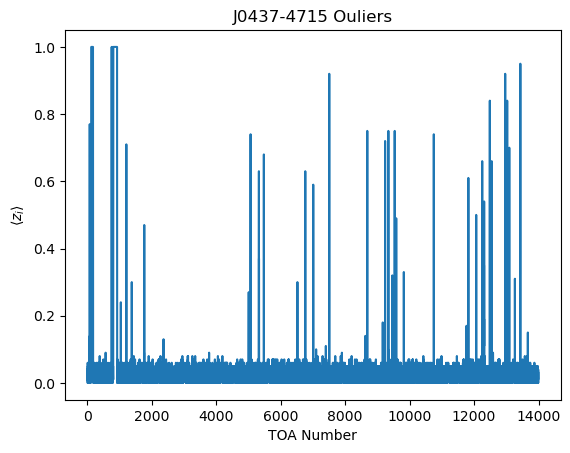

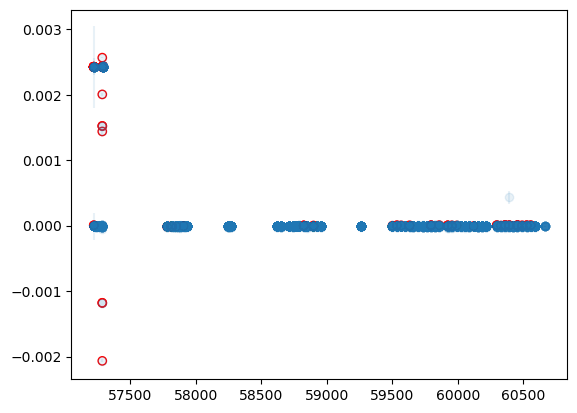

In [35]:
ds_psr = psr
plt.plot(np.mean(samples['z_i'], axis=0))
plt.title(f"{ds_psr.name} Ouliers")
plt.xlabel("TOA Number")
plt.ylabel("$\\langle z_i \\rangle$")
# plt.scatter([100, 345, 900, 1000], [1, 1, 1, 1], marker='o', facecolor='none', edgecolor='r')
# plt.yscale("log")
plt.show()
bad_toa_mask = np.mean(samples['z_i'], axis=0) > 0.1

plt.errorbar(ds_psr.toas / 86400, ds_psr.residuals, yerr=ds_psr.toaerrs, alpha=0.1, fmt='o')
plt.scatter(ds_psr.toas[bad_toa_mask] / 86400, ds_psr.residuals[bad_toa_mask], facecolor='none', edgecolor='r')
#plt.ylim(-1e-5, 1e-5)
plt.show()

In [ ]:
if run_outlier_analysis:
    if not load_pout: # load raw tims unless otherwise noted
        mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
        to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())
    else:
        mo,to = tc.get_model_and_toas(pout_tim_path=load_pout)
        to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())
        
    # Run outlier analysis and assign outlier probabilities to TOAs (narrowband only)
    # Skip calculate_pout if starting from pout.tim (load_pout is set)
    if not using_wideband:
        if not load_pout:
            tc.check_outlier()
            calculate_pout(mo, to, tc)       
        ou.make_pout_cuts(mo, to, tc, outpct_threshold=8.0)

    epochalyptica(mo,to,tc,nproc=epochdrop_threads)

if use_outlier_results:        
    mo,to = tc.get_model_and_toas(excised=True)
if (not run_outlier_analysis) and (not use_outlier_results):
    mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
    to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())

In [ ]:
# Quick breakdown of existing cut flags (automated excision)
cuts_dict = cut_summary(to,tc)

In [ ]:
# Apply manual cuts and check for redundancies
tc.manual_cuts(to)
to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())

In [ ]:
# More detailed breakdown of cuts by backend
plot_cuts_all_backends(to, save=True)

In [ ]:
# Plot residuals vs. time after auto/manual cuts
from pint_pal.plot_utils import plot_residuals_time
fo = tc.construct_fitter(to,mo)
plot_residuals_time(fo, restype='prefit')

In [ ]:
# Plot residuals & highlight manual cuts
highlight_cut_resids(to,mo,tc,ylim_good=True)

In [ ]:
# Fit if you want to analyze postfit residuals
if not autorun and analyze_postfit:
    fo.model.free_params = tc.get_free_params(fo)
    fo.fit_toas(maxiter=tc.get_niter())

In [ ]:
# Plot whitened residuals (if desired, plotsig: resid/uncertainty, avg: epoch-averaged)
if not autorun and analyze_postfit:
    plot_residuals_time(fo, restype='postfit', plotsig = False, avg = False, whitened = True)

Running display_excise_dropdowns (as below) will cause dropdowns for each bad-file and bad-toa of interest to be displayed. You should choose whatever combinations of file and plot type you'd like to make, then run the cell after this one (containing the read_excise_dropdowns functions) to read in your choices. The optional arguments all_YFp, all_GTpd, and all_profile will default the checkboxes to those plot types. If not specified, the default will be 'None' (i.e. do not plot). Finally, the make_detective_plots function (next cell) will display your plots. Note that bad_toa entries with "profile" plots selected will plot profiles for all bad subints and bad subbands of interest (as well as the integrated profile). 

In [ ]:
# Display checkboxes
if not autorun:
    file_select_list, file_pav_list, toa_select_list, toa_pav_list = \
        display_excise_dropdowns(file_matches, toa_matches, all_YFp=False, all_GTpd=False, all_profile=False)

As described above, this block will read your choices from the above dropdowns and make plots. Bad files and bad toas are dealt with separately to allow for future use of the bad-toa subint/subband info.

In [ ]:
# Make plots (indicated by dropdown choices)
if not autorun:
    file_plot_list = read_excise_dropdowns(file_select_list, file_pav_list, file_matches)
    toa_plot_list = read_excise_dropdowns(toa_select_list, toa_pav_list, toa_matches)
    make_detective_plots(file_plot_list, file_matches)
    make_detective_plots(toa_plot_list, toa_matches)

If you'd like to look at the cal file associated with any bad-file or bad-toa entry listed in the yaml, run the following two cells. Just as above, the first cell displays the checkboxes (which show the file name, not the cal name!). Then pick your plot types, and run the cell that follows to create the plots (in this case, there isn't a separate step to read the dropdowns).

In [ ]:
# Display cal file checkboxes
if not autorun: cal_select_list, full_cal_files = display_cal_dropdowns(file_matches, toa_matches)

In [ ]:
# Read dropdowns and make cal plots
if not autorun: read_plot_cal_dropdowns(cal_select_list, full_cal_files)

In [ ]:
# Print more detailed info about bad_toa entries
if not autorun:
    badtoas = tc.get_bad_toas()
    if badtoas:
        for bt in badtoas:
            tc.badtoa_info(bt,to)

The following cells allow you to visualize auto-excised TOA files. Specify the cut flags you want with "cutkeys" (default is ['epochdrop', 'outlier10']), then pick what kind of plot you want to see with plot_type ('profile' [default], 'GTpd', or 'YFp').

In [ ]:
# Look at profiles for auto-excised TOAs (outlier10):
if not autorun: plot_list = display_auto_ex(tc, mo, cutkeys=['outlier10'], plot_type='profile')

In [ ]:
# Look at freq. vs. phase for auto-excised TOAs (epochdrop):
if not autorun: plot_list = display_auto_ex(tc, mo, cutkeys=['epochdrop'], plot_type='GTpd')